In [1]:
# --- Cell 0: Compatible pair: torch 2.1.2 + torchtext 0.16.2 with CUDA support ---

print("Installing verified stable PyTorch + TorchText setup for GPU...")

# Uninstall existing PyTorch-related packages
!pip uninstall torch torchtext torchvision torchaudio torchtune -y -q

# Install GPU-compatible versions (CUDA 11.8 for broad compatibility)
!pip install torch==2.1.2 torchvision==0.16.2 torchtext==0.16.2 \
    --index-url https://download.pytorch.org/whl/cu118 -q

print("\n✅ Installation complete.")
print("="*60)
print("Restart runtime/session to finalize installation.")
print("="*60)

Installing verified stable PyTorch + TorchText setup for GPU...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 414.2 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 96.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 19.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 86.1 MB/s eta 0:00:00:00:01

✅ Installation complete.
Restart runtime/session to finalize installation.


In [2]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re

# PyTorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

print("Libraries imported successfully.")

Libraries imported successfully.


In [3]:
# ==============================================================
# Cell 2: Load the Dataset (Robust + Modern Pandas Compatible)
# ==============================================================

import pandas as pd
import csv

file_path = '/kaggle/input/empathetic-dialogues-facebook-ai/emotion-emotion_69k.csv'

try:
    # Load CSV safely even with messy commas and quotes
    df = pd.read_csv(
        file_path,
        encoding='utf-8',
        engine='python',         # safer parser
        quoting=csv.QUOTE_ALL,   # respect commas in quotes
        on_bad_lines='skip'      # modern replacement for error_bad_lines=False
    )

    # Clean up any weird spaces or invisible characters in headers
    df.columns = df.columns.str.strip()

    print("✅ Dataset loaded successfully.")
    print(f"Rows: {len(df)}, Columns: {len(df.columns)}")
    print("\nDetected columns:")
    print(df.columns.tolist())

    print("\nSample data (first 3 rows):")
    print(df.head(3))

except FileNotFoundError:
    print(f"❌ File not found at: {file_path}")
except pd.errors.ParserError as e:
    print("❌ Parsing failed due to malformed CSV structure.")
    print("Details:", e)


✅ Dataset loaded successfully.
Rows: 64636, Columns: 7

Detected columns:
['Unnamed: 0', 'Situation', 'emotion', 'empathetic_dialogues', 'labels', 'Unnamed: 5', 'Unnamed: 6']

Sample data (first 3 rows):
   Unnamed: 0                                          Situation      emotion  \
0           0  I remember going to the fireworks with my best...  sentimental   
1           1  I remember going to the fireworks with my best...  sentimental   
2           2  I remember going to the fireworks with my best...  sentimental   

                                empathetic_dialogues  \
0  Customer :I remember going to see the firework...   
1  Customer :This was a best friend. I miss her.\...   
2              Customer :We no longer talk.\nAgent :   

                                              labels Unnamed: 5 Unnamed: 6  
0  Was this a friend you were in love with, or ju...        NaN        NaN  
1                                Where has she gone?        NaN        NaN  
2  Oh was this 

Removed 12 duplicate rows.
Remaining rows after cleaning: 64620

✅ DataFrame successfully cleaned and restructured.

Cleaned DataFrame Head:
    emotion                                                                                                                Situation                                                                                                                                                                                 customer_utterance                                                     agent_reply
sentimental I remember going to the fireworks with my best friend. There was a lot of people, but it only felt like us in the world. I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people, we felt like the only people in the world. Was this a friend you were in love with, or just a best friend?
sentimental I remember going to the fireworks with my best friend. There wa

/tmp/ipykernel_37/1176252527.py:84: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


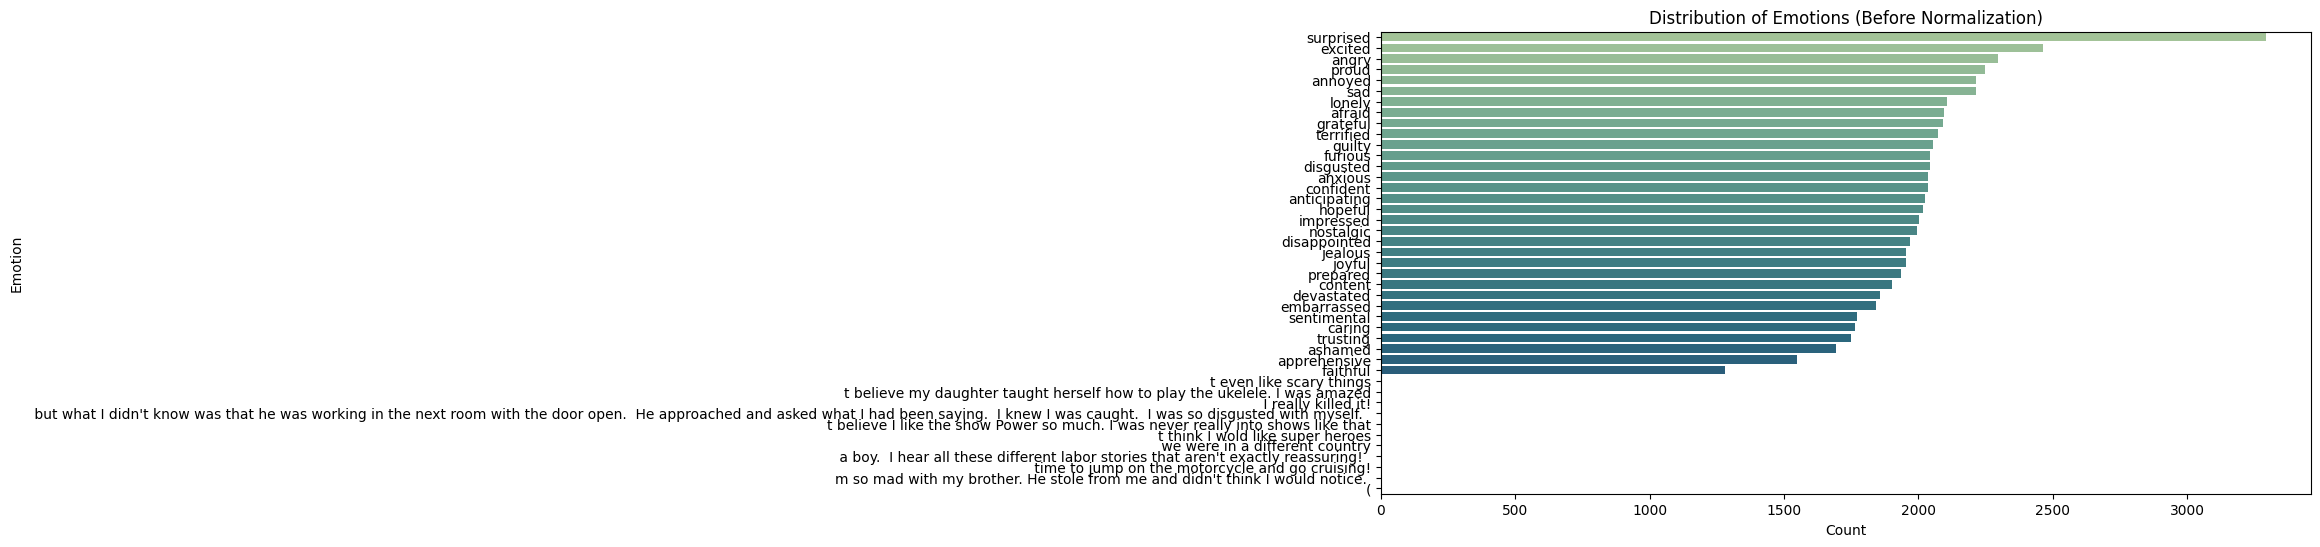

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


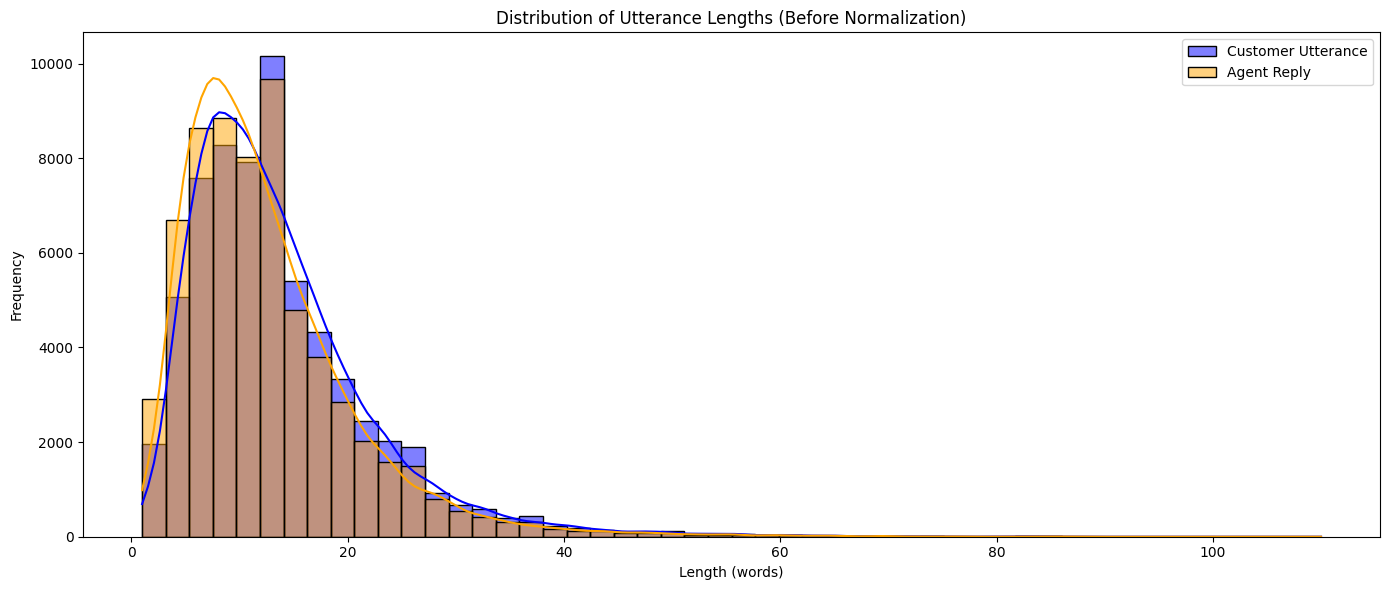

In [4]:
# ==============================================================
# ✅ Cell 3: Clean and Restructure the DataFrame (Updated & Robust)
# ==============================================================
# Purpose:
# - Handle missing or misaligned data safely
# - Extract clean customer and agent utterances
# - Ensure dataset integrity before normalization
# ==============================================================

import re
import html
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

if 'df' in locals():
    # ==============================================================
    # 1. Handle Missing Data and Drop Unnecessary Columns
    # ==============================================================
    # Drop rows with missing critical fields
    required_cols = ['emotion', 'Situation', 'empathetic_dialogues', 'labels']
    df.dropna(subset=required_cols, inplace=True)

    # Drop empty or whitespace-only strings
    for col in required_cols:
        df = df[df[col].astype(str).str.strip().astype(bool)]

    # ==============================================================
    # 2. Parse Dialogues to Extract Customer and Agent Utterances
    # ==============================================================
    def extract_customer_utterance(dialogue):
        """
        Extracts the customer's line from a dialogue like:
        'Customer : <text> \nAgent : <text>'
        Cleans prefixes, whitespace, and newline artifacts.
        """
        if pd.isna(dialogue):
            return ""
        text = str(dialogue)
        text = re.sub(r'^(customer)\s*:\s*', '', text, flags=re.IGNORECASE)
        text = re.sub(r'\s*\n\s*(agent)\s*:\s*$', '', text, flags=re.IGNORECASE)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    df['customer_utterance'] = df['empathetic_dialogues'].apply(extract_customer_utterance)
    df['agent_reply'] = df['labels'].astype(str).str.strip()

    # Drop rows where utterances are blank even after extraction
    df = df[
        df['customer_utterance'].str.strip().astype(bool)
        & df['agent_reply'].str.strip().astype(bool)
    ]

    # ==============================================================
    # 3. Create Final Clean DataFrame
    # ==============================================================
    clean_df = df[['emotion', 'Situation', 'customer_utterance', 'agent_reply']].copy()

    # Drop duplicate records
    before = len(clean_df)
    clean_df.drop_duplicates(subset=['emotion', 'customer_utterance', 'agent_reply'], inplace=True)
    after = len(clean_df)
    print(f"Removed {before - after} duplicate rows.")
    print(f"Remaining rows after cleaning: {after}")

    # ==============================================================
    # 4. Sanity Checks & Visualization
    # ==============================================================
    print("\n✅ DataFrame successfully cleaned and restructured.")
    print("\nCleaned DataFrame Head:")
    print(clean_df.head(3).to_string(index=False))

    # Emotion distribution (before normalization)
    plt.figure(figsize=(12, 6))
    sns.countplot(
        y=clean_df['emotion'],
        order=clean_df['emotion'].value_counts().index,
        palette='crest'
    )
    plt.title('Distribution of Emotions (Before Normalization)')
    plt.xlabel('Count')
    plt.ylabel('Emotion')
    plt.tight_layout()
    plt.show()

    # ==============================================================
    # 5. Utterance Length Distributions
    # ==============================================================
    clean_df['customer_utterance_length'] = clean_df['customer_utterance'].apply(lambda x: len(x.split()))
    clean_df['agent_reply_length'] = clean_df['agent_reply'].apply(lambda x: len(x.split()))

    plt.figure(figsize=(14, 6))
    sns.histplot(clean_df['customer_utterance_length'], bins=50, kde=True, color='blue', label='Customer Utterance')
    sns.histplot(clean_df['agent_reply_length'], bins=50, kde=True, color='orange', label='Agent Reply')
    plt.title('Distribution of Utterance Lengths (Before Normalization)')
    plt.xlabel('Length (words)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()


Text normalization applied successfully to the cleaned DataFrame.
Final Cleaned Dataset Size: 64475

Example of normalized text:
  emotion                                                                       Situation                                                                                            customer_utterance                                                                                agent_reply  customer_utterance_length  agent_reply_length
impressed                i've been very pleased with my daughters' musical performances .                            my daughters are musicians , the youngest a pianist , and the oldest a violinist . i congratulate you on your children . . . . that says a lot about you as a father o mother                         13                  18
   joyful                                         i found out my wife is pregnant today !                                                                                    oh wow , congratulatio

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


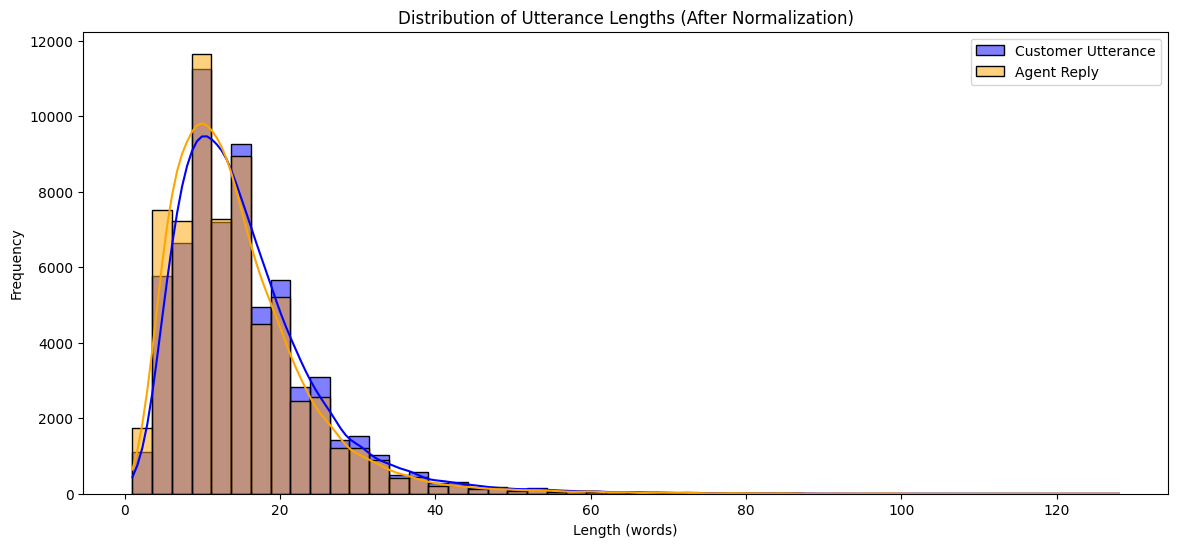

In [5]:
# ==============================================================
# Cell 4: Text Normalization
# ==============================================================
# Requirements:
# - Lowercase text
# - Clean whitespace
# - Normalize punctuation
# - Remove/control unwanted symbols, emojis, URLs, HTML, etc.
# ==============================================================

def normalize_text(text):
    """
    Advanced normalization for transformer-based NLP.
    - Lowercase the text
    - Unicode NFKC normalization
    - Replace URLs, emails, and phone numbers with placeholders
    - Unescape HTML entities
    - Remove control characters and emojis
    - Normalize punctuation spacing
    - Collapse extra whitespace
    """
    if pd.isna(text):
        return ""
    text = str(text)

    # Normalize Unicode (so accents, diacritics, symbols are consistent)
    text = unicodedata.normalize("NFKC", text)

    # Decode HTML entities (e.g., &amp; -> &)
    text = html.unescape(text)

    # Replace URLs, emails, and phone numbers with tokens
    text = re.sub(r'https?://\S+|www\.\S+', '<URL>', text)
    text = re.sub(r'\S+@\S+\.\S+', '<EMAIL>', text)
    text = re.sub(r'\+?\d[\d\-\s]{6,}\d', '<PHONE>', text)

    # Remove emojis and non-text characters
    text = re.sub(r'[\U00010000-\U0010ffff]', '', text)

    # Lowercase
    text = text.lower()

    # Space around punctuation
    text = re.sub(r"([?.!,])", r" \1 ", text)

    # Remove stray special chars (HTML tags, quotes, etc.)
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'["“”]+', '', text)
    text = re.sub(r"[^a-z0-9<>\s?.!,']", " ", text)  # keep punctuation & placeholders

    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text


if 'clean_df' in locals():
    # Apply normalization
    clean_df['Situation'] = clean_df['Situation'].apply(normalize_text)
    clean_df['customer_utterance'] = clean_df['customer_utterance'].apply(normalize_text)
    clean_df['agent_reply'] = clean_df['agent_reply'].apply(normalize_text)

    # Filter extremely short utterances (junk rows)
    clean_df = clean_df[(clean_df['customer_utterance'].str.len() > 2) &
                        (clean_df['agent_reply'].str.len() > 2)].copy()

    print("Text normalization applied successfully to the cleaned DataFrame.")
    print(f"Final Cleaned Dataset Size: {len(clean_df)}")
    print("\nExample of normalized text:")
    print(clean_df.sample(3).to_string(index=False))

    # Visualization: lengths after normalization
    clean_df['customer_utterance_length'] = clean_df['customer_utterance'].apply(lambda x: len(x.split()))
    clean_df['agent_reply_length'] = clean_df['agent_reply'].apply(lambda x: len(x.split()))

    plt.figure(figsize=(14, 6))
    sns.histplot(clean_df['customer_utterance_length'], bins=50, kde=True, color='blue', label='Customer Utterance')
    sns.histplot(clean_df['agent_reply_length'], bins=50, kde=True, color='orange', label='Agent Reply')
    plt.title('Distribution of Utterance Lengths (After Normalization)')
    plt.xlabel('Length (words)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


Emotion Distribution (Counts):
emotion
surprised                                                                                                                                                                                         3288
excited                                                                                                                                                                                           2461
angry                                                                                                                                                                                             2295
proud                                                                                                                                                                                             2234
sad                                                                                                                                                                  

/tmp/ipykernel_37/849871913.py:32: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


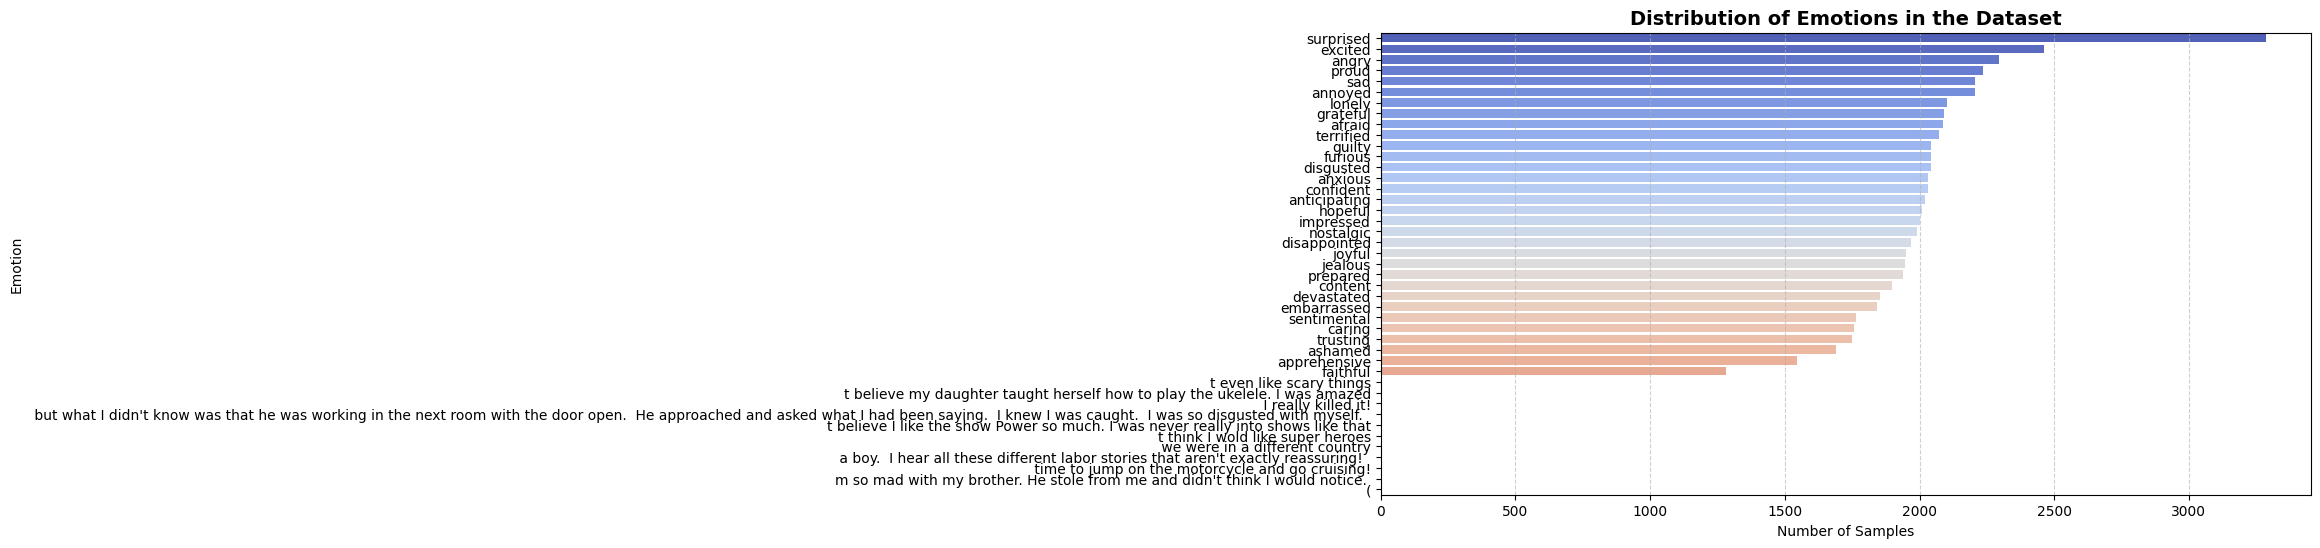

In [6]:
# Cell 5: Emotion Distribution Analysis
# ---
# Before model training, it's important to inspect label balance.
# This helps confirm that our stratified split is effective and that
# no emotion dominates the dataset.
# ---

import matplotlib.pyplot as plt
import seaborn as sns

if 'clean_df' in locals():
    # Count emotion occurrences
    emotion_counts = clean_df['emotion'].value_counts().sort_values(ascending=False)

    # Display raw counts and proportions
    print("Emotion Distribution (Counts):")
    print(emotion_counts)
    print("\nEmotion Distribution (Percentages):")
    print((emotion_counts / len(clean_df) * 100).round(2))

    # --- Visualization ---
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=emotion_counts.values,
        y=emotion_counts.index,
        palette="coolwarm"
    )
    plt.title("Distribution of Emotions in the Dataset", fontsize=14, fontweight='bold')
    plt.xlabel("Number of Samples")
    plt.ylabel("Emotion")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


In [7]:
# Cell 6: Validate and Clean Emotion Column
# ---
# Some rows have invalid emotion values (e.g., misaligned text or corrupted rows).
# We'll filter the dataset to keep only valid emotion labels.
# ---

valid_emotions = {
    'afraid', 'angry', 'annoyed', 'anticipating', 'anxious', 'apprehensive', 
    'ashamed', 'caring', 'confident', 'content', 'devastated', 'disappointed', 
    'disgusted', 'embarrassed', 'excited', 'faithful', 'furious', 'grateful', 
    'guilty', 'hopeful', 'impressed', 'jealous', 'joyful', 'lonely', 'nostalgic', 
    'prepared', 'proud', 'sad', 'sentimental', 'surprised', 'terrified', 'trusting'
}

if 'clean_df' in locals():
    before_count = len(clean_df)
    
    clean_df = clean_df[clean_df['emotion'].isin(valid_emotions)].copy()
    after_count = len(clean_df)
    
    print(f"Removed {before_count - after_count} invalid rows with corrupted emotion labels.")
    print(f"Remaining rows: {after_count}")

    # Optional sanity check
    print("\nUnique emotions remaining:")
    print(sorted(clean_df['emotion'].unique()))


Removed 41 invalid rows with corrupted emotion labels.
Remaining rows: 64434

Unique emotions remaining:
['afraid', 'angry', 'annoyed', 'anticipating', 'anxious', 'apprehensive', 'ashamed', 'caring', 'confident', 'content', 'devastated', 'disappointed', 'disgusted', 'embarrassed', 'excited', 'faithful', 'furious', 'grateful', 'guilty', 'hopeful', 'impressed', 'jealous', 'joyful', 'lonely', 'nostalgic', 'prepared', 'proud', 'sad', 'sentimental', 'surprised', 'terrified', 'trusting']


In [8]:
# Cell 7 : Split the Dataset
# ---
# We split our clean and processed DataFrame. This is the final step
# before we start building the vocabulary and data loaders.
# ---

from sklearn.model_selection import train_test_split

if 'clean_df' in locals():
    # Ensure no missing labels before stratification
    clean_df = clean_df.dropna(subset=['emotion'])

    # First, split into training (80%) and a temporary set (20%)
    train_df, temp_df = train_test_split(
        clean_df, 
        test_size=0.2, 
        stratify=clean_df['emotion'],  # keeps emotion proportions consistent
        random_state=42
    )

    # Then, split the temporary set into validation (10%) and test (10%)
    val_df, test_df = train_test_split(
        temp_df, 
        test_size=0.5, 
        stratify=temp_df['emotion'],
        random_state=42
    )

    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")
    print(f"Test set size: {len(test_df)}")

    # Save the splits to CSV files for later use
    train_df.to_csv('train.csv', index=False)
    val_df.to_csv('val.csv', index=False)
    test_df.to_csv('test.csv', index=False)

    print("\nTrain, validation, and test sets have been created and saved (with stratification).")


Training set size: 51547
Validation set size: 6443
Test set size: 6444

Train, validation, and test sets have been created and saved (with stratification).


In [9]:
# ==========================================================
# Fixed Cell 8: Train BPE Tokenizer + Add Emotion Tokens
# ==========================================================
from tokenizers import Tokenizer, models, pre_tokenizers, trainers, normalizers, processors
import os

# Define standard special tokens (added <sep>)
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX, SEP_IDX = 0, 1, 2, 3, 4
special_tokens = ['<unk>', '<pad>', '<bos>', '<eos>', '<sep>']

# Create emotion tokens dynamically from training set
unique_emotions = sorted(train_df['emotion'].unique())
emotion_tokens = [f'<emotion_{emo}>' for emo in unique_emotions]
all_special_tokens = special_tokens + emotion_tokens

# Combine all text columns for training tokenizer
train_texts = (
    train_df['Situation'].astype(str).tolist() +
    train_df['customer_utterance'].astype(str).tolist() +
    train_df['agent_reply'].astype(str).tolist()
)

# Train a Byte-Pair Encoding (BPE) tokenizer
tokenizer = Tokenizer(models.BPE(unk_token='<unk>'))
tokenizer.normalizer = normalizers.Sequence([normalizers.NFD(), normalizers.Lowercase()])
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

trainer = trainers.BpeTrainer(
    vocab_size=16000,  # good for 50k+ samples
    min_frequency=2,
    special_tokens=all_special_tokens
)

tokenizer.train_from_iterator(train_texts, trainer=trainer)

tokenizer.post_processor = processors.TemplateProcessing(
    single="<bos> $A <eos>",
    pair="<bos> $A <sep> $B <eos>",
    special_tokens=[
        ("<bos>", BOS_IDX),
        ("<eos>", EOS_IDX),
        ("<pad>", PAD_IDX),
        ("<sep>", SEP_IDX)
    ],
)

# Save tokenizer for reuse
os.makedirs("tokenizer", exist_ok=True)
tokenizer.save("tokenizer/empathetic_bpe_tokenizer.json")

print("✅ Fixed: BPE Tokenizer trained and saved.")
print("Vocabulary size:", tokenizer.get_vocab_size())
print("Example emotion token index (trusting):", tokenizer.token_to_id("<emotion_trusting>"))





✅ Fixed: BPE Tokenizer trained and saved.
Vocabulary size: 16000
Example emotion token index (trusting): 36


In [10]:
# ==========================================================
# Cell 9: Dataset Class for BPE-based Tokenizer
# ==========================================================
import torch
from torch.utils.data import Dataset
from tokenizers import Tokenizer

# Load the saved tokenizer
tokenizer = Tokenizer.from_file("tokenizer/empathetic_bpe_tokenizer.json")

class EmpatheticDataset(Dataset):
    def __init__(self, df, tokenizer, emotion_col='emotion'):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.emotion_col = emotion_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Prepend emotion token to source input
        emotion_token = f"<emotion_{row[self.emotion_col]}> "
        source_text = emotion_token + str(row['Situation']) + " " + str(row['customer_utterance'])
        target_text = str(row['agent_reply'])

        # Encode using the trained tokenizer
        src_enc = self.tokenizer.encode(source_text)
        tgt_enc = self.tokenizer.encode(target_text)

        # Convert to tensors
        src_tensor = torch.tensor(src_enc.ids, dtype=torch.long)
        tgt_tensor = torch.tensor(tgt_enc.ids, dtype=torch.long)

        return src_tensor, tgt_tensor


In [11]:
# ==========================================================
# Cell 10: DataLoader with Dynamic Padding
# ==========================================================
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

PAD_IDX = tokenizer.token_to_id("<pad>")

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, tgt_batch

# Hyperparameters
BATCH_SIZE = 32

# Instantiate datasets for all splits
train_dataset = EmpatheticDataset(train_df, tokenizer)
val_dataset = EmpatheticDataset(val_df, tokenizer)
test_dataset = EmpatheticDataset(test_df, tokenizer)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print("✅ DataLoaders created successfully.")

# Inspect a sample batch
src_batch, tgt_batch = next(iter(train_dataloader))
print(f"Source batch shape: {src_batch.shape}")
print(f"Target batch shape: {tgt_batch.shape}")

✅ DataLoaders created successfully.
Source batch shape: torch.Size([32, 109])
Target batch shape: torch.Size([32, 80])


In [23]:
# ==========================================================
# Cell 11 (Finalized & Compatible with BPE Tokenizer)
# ==========================================================
import torch
import torch.nn as nn
import math

# ====== 1. Hyperparameters ======
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

VOCAB_SIZE = tokenizer.get_vocab_size()   # <-- FIXED for BPE tokenizer
EMBED_DIM = 512
NUM_HEADS = 2
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
DROPOUT = 0.1
MAX_LEN = 500
BATCH_SIZE = 32
LR = 1e-4
BETAS = (0.9, 0.98)

# Extract special token IDs for later use (masking, padding, etc.)
PAD_IDX = tokenizer.token_to_id("<pad>")
BOS_IDX = tokenizer.token_to_id("<bos>")
EOS_IDX = tokenizer.token_to_id("<eos>")
SEP_IDX = tokenizer.token_to_id("<sep>")

print(f"Device: {DEVICE}")
print(f"Config -> Embedding: {EMBED_DIM}, Heads: {NUM_HEADS}, Encoder Layers: {NUM_ENCODER_LAYERS}, Decoder Layers: {NUM_DECODER_LAYERS}")
print(f"Tokenizer vocab size: {VOCAB_SIZE}")

# ====== 2. Positional Encoding ======
class PositionalEncoding(nn.Module):
    def __init__(self, emb_dim: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_dim, 2) * (-math.log(10000.0) / emb_dim))
        pe = torch.zeros(max_len, emb_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))  # shape: [1, max_len, emb_dim]

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)


Device: cuda
Config -> Embedding: 512, Heads: 2, Encoder Layers: 2, Decoder Layers: 2
Tokenizer vocab size: 16000


In [24]:
# ==========================================================
# Cell 12: Multi-Head Attention (Updated & Optimized)
# ==========================================================
import torch
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim: int, num_heads: int, dropout: float):
        super().__init__()
        assert emb_dim % num_heads == 0, "Embedding dimension must be divisible by num_heads"

        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = emb_dim // num_heads

        self.fc_q = nn.Linear(emb_dim, emb_dim)
        self.fc_k = nn.Linear(emb_dim, emb_dim)
        self.fc_v = nn.Linear(emb_dim, emb_dim)
        self.fc_out = nn.Linear(emb_dim, emb_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32, device=DEVICE))

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Split into heads
        Q = Q.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.head_dim).transpose(1, 2)

        energy = torch.matmul(Q, K.transpose(-2, -1)) / self.scale

        if mask is not None:
            # mask: [batch_size, 1, 1, key_len]
            energy = energy.masked_fill(mask == 0, float('-inf'))

        attn = torch.softmax(energy, dim=-1)
        x = torch.matmul(self.dropout(attn), V)

        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.emb_dim)
        x = self.fc_out(x)

        return x, attn

In [25]:
# ==========================================================
# Cell 13: Position-wise Feed-Forward Network (Updated)
# ==========================================================
class PositionwiseFeedforward(nn.Module):
    def __init__(self, emb_dim: int, ff_dim: int = 2048, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(emb_dim, ff_dim)
        self.linear2 = nn.Linear(ff_dim, emb_dim)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.linear2(self.dropout(self.relu(self.linear1(x))))


In [26]:
# Cell 14: Encoder Layer
# ---
# This module combines Multi-Head Attention and a Feed-Forward network to form
# one layer of the Transformer encoder. It includes residual connections and
# layer normalization, which are crucial for training deep Transformers.
# ---
class EncoderLayer(nn.Module):
    def __init__(self, emb_dim: int, num_heads: int, ff_dim: int, dropout: float):
        super().__init__()
        
        self.self_attn = MultiHeadAttention(emb_dim, num_heads, dropout)
        self.feed_forward = PositionwiseFeedforward(emb_dim, ff_dim, dropout)
        
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        # src shape: [batch_size, src_len, emb_dim]
        # src_mask shape: [batch_size, 1, 1, src_len]

        # 1. Self-Attention
        # The query, key, and value are all the same: the source sentence.
        _src, _ = self.self_attn(src, src, src, src_mask)
        
        # 2. Residual connection and Layer Normalization
        src = self.norm1(src + self.dropout(_src))
        
        # 3. Feed-Forward
        _src = self.feed_forward(src)
        
        # 4. Residual connection and Layer Normalization
        src = self.norm2(src + self.dropout(_src))
        
        return src

In [27]:
# Cell 15: Decoder Layer
# ---
# The Decoder Layer is more complex. It has two attention mechanisms: one for the
# target sequence (masked) and one for attending to the encoder's output.
# ---
class DecoderLayer(nn.Module):
    def __init__(self, emb_dim: int, num_heads: int, ff_dim: int, dropout: float):
        super().__init__()
        
        self.self_attn = MultiHeadAttention(emb_dim, num_heads, dropout)
        self.encoder_attn = MultiHeadAttention(emb_dim, num_heads, dropout)
        self.feed_forward = PositionwiseFeedforward(emb_dim, ff_dim, dropout)
        
        self.norm1 = nn.LayerNorm(emb_dim)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.norm3 = nn.LayerNorm(emb_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg: [batch_size, trg_len, emb_dim]
        # enc_src: [batch_size, src_len, emb_dim]
        # trg_mask: [batch_size, 1, trg_len, trg_len]
        # src_mask: [batch_size, 1, 1, src_len]
        
        # 1. Masked Self-Attention (on the target sequence)
        _trg, _ = self.self_attn(trg, trg, trg, trg_mask)
        trg = self.norm1(trg + self.dropout(_trg))
        
        # 2. Encoder-Decoder Attention
        # Query is from the decoder, Key and Value are from the encoder's output.
        _trg, attention = self.encoder_attn(trg, enc_src, enc_src, src_mask)
        trg = self.norm2(trg + self.dropout(_trg))
        
        # 3. Feed-Forward
        _trg = self.feed_forward(trg)
        trg = self.norm3(trg + self.dropout(_trg))
        
        return trg, attention

In [28]:
# Cell 16: The Full Encoder
# ---
# This class stacks multiple EncoderLayers. It is responsible for taking the raw
# source sentence indices, embedding them, adding positional encoding, and then
# passing them through the stack of layers.
# ---
class Encoder(nn.Module):
    def __init__(self,
                 input_dim: int, # Vocabulary size
                 emb_dim: int,
                 num_layers: int,
                 num_heads: int,
                 ff_dim: int,
                 dropout: float,
                 device: torch.device):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, emb_dim)
        self.pos_embedding = PositionalEncoding(emb_dim, dropout)
        
        self.layers = nn.ModuleList([EncoderLayer(emb_dim, num_heads, ff_dim, dropout) 
                                     for _ in range(num_layers)])
        
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([emb_dim])).to(device)
        
    def forward(self, src, src_mask):
        # src: [batch_size, src_len]
        # src_mask: [batch_size, 1, 1, src_len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        # 1. Apply embedding and positional encoding
        # Note: The original paper multiplies the embedding by scale.
        tok_embedded = self.tok_embedding(src) * self.scale
        
        # The PositionalEncoding class expects [seq_len, batch_size, emb_dim],
        # so we need to permute the dimensions.
        pos_embedded = self.pos_embedding(tok_embedded.permute(1, 0, 2)).permute(1, 0, 2)
        
        src = self.dropout(pos_embedded)
        
        # 2. Pass through N encoder layers
        for layer in self.layers:
            src = layer(src, src_mask)
            
        return src # Final contextual representation

In [29]:
# Cell 17: The Full Decoder
# ---
# This class stacks multiple DecoderLayers. It embeds the target sequence, adds
# positional context, and importantly, uses the output from the Encoder via
# the Encoder-Decoder attention mechanism to generate the output sequence.
# ---
class Decoder(nn.Module):
    def __init__(self,
                 output_dim: int, # Vocabulary size
                 emb_dim: int,
                 num_layers: int,
                 num_heads: int,
                 ff_dim: int,
                 dropout: float,
                 device: torch.device):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = PositionalEncoding(emb_dim, dropout)
        
        self.layers = nn.ModuleList([DecoderLayer(emb_dim, num_heads, ff_dim, dropout)
                                     for _ in range(num_layers)])
                                     
        self.fc_out = nn.Linear(emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([emb_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, emb_dim]
        # trg_mask: [batch_size, 1, trg_len, trg_len]
        # src_mask: [batch_size, 1, 1, src_len]
        
        # 1. Apply embedding and positional encoding
        tok_embedded = self.tok_embedding(trg) * self.scale
        pos_embedded = self.pos_embedding(tok_embedded.permute(1, 0, 2)).permute(1, 0, 2)
        trg = self.dropout(pos_embedded)
        
        # 2. Pass through N decoder layers
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        # 3. Final linear layer to get vocabulary predictions
        output = self.fc_out(trg)
        
        return output, attention

In [38]:
# Cell 18: The Complete Seq2Seq Transformer Model
# ---
# This master class brings everything together. It contains the Encoder and Decoder,
# and its most critical role is to create the padding and look-ahead masks
# that are required for the attention mechanisms to work correctly.
# ---
import torch
import torch.nn as nn

class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 encoder: Encoder,
                 decoder: Decoder,
                 src_pad_idx: int,
                 trg_pad_idx: int,
                 device: torch.device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        self._initialize_weights()

    def _initialize_weights(self):
        # A common practice for initializing weights for better training stability
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def make_src_mask(self, src):
        # src: [batch_size, src_len]
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # Final shape: [batch_size, 1, 1, src_len]
        return src_mask

    def make_trg_mask(self, trg):
        # trg: [batch_size, trg_len]
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()
        trg_mask = trg_pad_mask & trg_sub_mask
        # Final shape: [batch_size, 1, trg_len, trg_len]
        return trg_mask

    # --- Added Missing Method ---
    def generate_square_subsequent_mask(self, sz: int) -> torch.Tensor:
        """Generate a square mask to hide future tokens (used in decoder)."""
        mask = torch.triu(torch.ones(sz, sz, device=self.device) * float('-inf'), diagonal=1)
        return mask
    # ----------------------------

    def forward(self, src, trg, tgt_mask=None):
        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        enc_src = self.encoder(src, src_mask)
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        return output, attention


# --- Instantiate the final model ---
FF_DIM = 4 * EMBED_DIM  # A common rule of thumb for feed-forward dimension
encoder = Encoder(VOCAB_SIZE, EMBED_DIM, NUM_ENCODER_LAYERS, NUM_HEADS, FF_DIM, DROPOUT, DEVICE)
decoder = Decoder(VOCAB_SIZE, EMBED_DIM, NUM_DECODER_LAYERS, NUM_HEADS, FF_DIM, DROPOUT, DEVICE)
model = Seq2SeqTransformer(encoder, decoder, PAD_IDX, PAD_IDX, DEVICE).to(DEVICE)

print(model)

def count_parameters(model: nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'\nThe model has {count_parameters(model):,} trainable parameters')


Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(16000, 512)
    (pos_embedding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (fc_q): Linear(in_features=512, out_features=512, bias=True)
          (fc_k): Linear(in_features=512, out_features=512, bias=True)
          (fc_v): Linear(in_features=512, out_features=512, bias=True)
          (fc_out): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedforward(
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (relu): ReLU()
        )
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): Lay

In [21]:
# Cell 19: Install tqdm for Progress Bars
# ---
# A professional training script requires progress monitoring.
# We will use tqdm, a standard library for creating smart, informative progress bars.
# ---
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
!pip install tqdm -q
from tqdm import tqdm
print("tqdm installed and imported successfully.")

tqdm installed and imported successfully.


In [39]:
# --- Cell 20: Stable Optimizer and Scheduler ---
# Ensures correct initialization, stable training with OneCycleLR, and compatibility with CUDA.

import torch
import torch.nn as nn
import torch.optim as optim

# --- Set hyperparameters and constants ---
N_EPOCHS = 15          # Number of epochs defined BEFORE use
LEARNING_RATE = 2e-4
CLIP = 1.0
BEST_MODEL_PATH = 'best-model-v4-stable.pt'
CHECKPOINT_PATH = 'latest-checkpoint-v4-stable.pt'

# --- Reinitialize model from scratch to avoid corrupted weights ---
encoder = Encoder(VOCAB_SIZE, EMBED_DIM, NUM_ENCODER_LAYERS, NUM_HEADS, FF_DIM, DROPOUT, DEVICE)
decoder = Decoder(VOCAB_SIZE, EMBED_DIM, NUM_DECODER_LAYERS, NUM_HEADS, FF_DIM, DROPOUT, DEVICE)
model = Seq2SeqTransformer(encoder, decoder, PAD_IDX, PAD_IDX, DEVICE).to(DEVICE)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9)

# --- Scheduler setup ---
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=LEARNING_RATE,
    total_steps=len(train_dataloader) * N_EPOCHS
)

print("✅ Model, optimizer, and scheduler initialized successfully.")


✅ Model, optimizer, and scheduler initialized successfully.


In [41]:
# --- Cell 21: Training Loop ---
from tqdm import tqdm

def train_epoch(model: nn.Module,
                iterator: torch.utils.data.DataLoader,
                optimizer: optim.Optimizer,
                criterion: nn.Module,
                clip: float,
                scheduler: torch.optim.lr_scheduler._LRScheduler):
    
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(iterator, desc="Training", leave=False)
    
    for i, batch in enumerate(progress_bar):
        src, trg = batch
        src, trg = src.to(DEVICE), trg.to(DEVICE)

        optimizer.zero_grad()
        trg_input = trg[:, :-1]

        # ---- Ensure causal masking for decoder ----
        tgt_mask = model.generate_square_subsequent_mask(trg_input.size(1)).to(DEVICE)

        output, _ = model(src, trg_input, tgt_mask=tgt_mask)

        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg_output = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output, trg_output)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item(), lr=scheduler.get_last_lr()[0])
    
    return epoch_loss / len(iterator)


In [42]:
# --- Cell 22: Evaluation Loop ---
from tqdm import tqdm

def evaluate(model: nn.Module,
             iterator: torch.utils.data.DataLoader,
             criterion: nn.Module):
    
    model.eval()
    epoch_loss = 0
    progress_bar = tqdm(iterator, desc="Evaluating", leave=False)

    with torch.no_grad():
        for batch in progress_bar:
            src, trg = batch
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            trg_input = trg[:, :-1]
            tgt_mask = model.generate_square_subsequent_mask(trg_input.size(1)).to(DEVICE)

            output, _ = model(src, trg_input, tgt_mask=tgt_mask)
            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg_output = trg[:, 1:].contiguous().view(-1)

            loss = criterion(output, trg_output)
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(iterator)


In [43]:
# --- Cell 23: Training Runner with Checkpoints & Sanity Check ---

import time, math, torch

resume_training = False
start_epoch = 0
best_valid_loss = float('inf')

# --- Optional sanity check (verify overfitting on small subset) ---
# Uncomment to run a quick overfit test
# train_dataloader = torch.utils.data.DataLoader(list(train_dataloader)[:100], batch_size=BATCH_SIZE)

if resume_training and os.path.exists(CHECKPOINT_PATH):
    checkpoint = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_valid_loss = checkpoint['best_valid_loss']
    print(f"Resumed from epoch {start_epoch}, best validation loss {best_valid_loss:.3f}")

for epoch in range(start_epoch, N_EPOCHS):
    start_time = time.time()

    train_loss = train_epoch(model, train_dataloader, optimizer, criterion, CLIP, scheduler)
    valid_loss = evaluate(model, val_dataloader, criterion)

    end_time = time.time()
    mins, secs = divmod(end_time - start_time, 60)

    print(f"Epoch {epoch+1:02} | Time: {int(mins)}m {int(secs)}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}")
    print(f"\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}")

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"\t✨ New best model saved to {BEST_MODEL_PATH}")

    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_valid_loss': best_valid_loss,
    }, CHECKPOINT_PATH)
    print(f"\t💾 Checkpoint saved to {CHECKPOINT_PATH}")


Epoch 01 | Time: 3m 22s
	Train Loss: 6.354 | Train PPL: 574.792
	 Val. Loss: 4.982 |  Val. PPL: 145.791
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch 02 | Time: 3m 23s
	Train Loss: 4.635 | Train PPL: 103.063
	 Val. Loss: 4.347 |  Val. PPL:  77.285
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch 03 | Time: 3m 22s
	Train Loss: 4.247 | Train PPL:  69.897
	 Val. Loss: 4.123 |  Val. PPL:  61.729
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch 04 | Time: 3m 22s
	Train Loss: 4.048 | Train PPL:  57.255
	 Val. Loss: 3.992 |  Val. PPL:  54.154
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch 05 | Time: 3m 22s
	Train Loss: 3.903 | Train PPL:  49.545
	 Val. Loss: 3.902 |  Val. PPL:  49.523
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch 06 | Time: 3m 22s
	Train Loss: 3.784 | Train PPL:  43.971
	 Val. Loss: 3.823 |  Val. PPL:  45.755
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch 07 | Time: 3m 21s
	Train Loss: 3.680 | Train PPL:  39.629
	 Val. Loss: 3.796 |  Val. PPL:  44.504
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch 08 | Time: 3m 21s
	Train Loss: 3.586 | Train PPL:  36.080
	 Val. Loss: 3.777 |  Val. PPL:  43.700
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch 09 | Time: 3m 22s
	Train Loss: 3.497 | Train PPL:  33.010
	 Val. Loss: 3.755 |  Val. PPL:  42.718
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch 10 | Time: 3m 22s
	Train Loss: 3.411 | Train PPL:  30.294
	 Val. Loss: 3.747 |  Val. PPL:  42.405
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch 11 | Time: 3m 21s
	Train Loss: 3.332 | Train PPL:  27.996
	 Val. Loss: 3.732 |  Val. PPL:  41.775
	✨ New best model saved to best-model-v4-stable.pt
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch 12 | Time: 3m 21s
	Train Loss: 3.264 | Train PPL:  26.142
	 Val. Loss: 3.749 |  Val. PPL:  42.474
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch 13 | Time: 3m 21s
	Train Loss: 3.209 | Train PPL:  24.756
	 Val. Loss: 3.756 |  Val. PPL:  42.776
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch 14 | Time: 3m 22s
	Train Loss: 3.174 | Train PPL:  23.898
	 Val. Loss: 3.755 |  Val. PPL:  42.741
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


Epoch 15 | Time: 3m 22s
	Train Loss: 3.154 | Train PPL:  23.429
	 Val. Loss: 3.755 |  Val. PPL:  42.743
	💾 Checkpoint saved to latest-checkpoint-v4-stable.pt


In [44]:
# Cell 24: Install Evaluation Libraries
# ---
# To calculate BLEU and ROUGE scores, we will use the torchmetrics library.
# It provides efficient and validated implementations of these complex metrics.
# ---
!pip install torchmetrics sacrebleu -q
import torchmetrics
from torchmetrics.text import BLEUScore, ROUGEScore  # Correct import
print("Evaluation libraries installed successfully.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.4 MB/s eta 0:00:00
Evaluation libraries installed successfully.


In [45]:
# Cell 25: Load the Best-Performing Model
# ---
# We load the saved state_dict from our training phase into a fresh instance
# of our model architecture. The model is set to evaluation mode.
# ---
# Re-initialize the model architecture (ensure all classes from Phase 3 are in memory)
encoder = Encoder(VOCAB_SIZE, EMBED_DIM, NUM_ENCODER_LAYERS, NUM_HEADS, FF_DIM, DROPOUT, DEVICE)
decoder = Decoder(VOCAB_SIZE, EMBED_DIM, NUM_DECODER_LAYERS, NUM_HEADS, FF_DIM, DROPOUT, DEVICE)
model = Seq2SeqTransformer(encoder, decoder, PAD_IDX, PAD_IDX, DEVICE).to(DEVICE)

# Load the saved weights
model.load_state_dict(torch.load('best-model-v4-stable.pt', map_location=DEVICE))

# Set the model to evaluation mode
model.eval()
print("Best model loaded and set to evaluation mode.")

Best model loaded and set to evaluation mode.


In [46]:
# Cell 26 (Updated): Greedy Search Decoding Function using BPE tokenizer
def greedy_decode(model, src_sentence, max_len=50):
    model.eval()

    # Encode source (tokenizer post-processor already adds BOS/EOS if configured)
    enc = tokenizer.encode(src_sentence)
    src_ids = enc.ids
    src_tensor = torch.LongTensor(src_ids).unsqueeze(0).to(DEVICE)  # (1, src_len)
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # Start decoding with BOS token
    trg_indexes = [BOS_IDX]

    attention = None
    for _ in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(DEVICE)
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        next_token = int(output.argmax(-1)[:, -1].item())
        trg_indexes.append(next_token)

        if next_token == EOS_IDX:
            break

    # Decode ids to string (skip special tokens)
    try:
        decoded = tokenizer.decode(trg_indexes, skip_special_tokens=True)
    except TypeError:
        # older tokenizers versions may not support skip_special_tokens flag
        decoded = tokenizer.decode(trg_indexes)
        # remove known special tokens if present
        for t in ["<bos>", "<eos>", "<pad>", "<sep>"]:
            decoded = decoded.replace(t, "")
        decoded = decoded.strip()

    return decoded, attention


In [47]:
# Cell 27 (Updated): Generate a few qualitative examples from test set
for i in range(5):
    row = test_df.iloc[i]
    input_text = f"Emotion: {row['emotion']} | Situation: {row['Situation']} | Customer: {row['customer_utterance']} Agent:"
    print(f"--- Example {i+1} ---")
    print("RAW INPUT:", input_text)

    predicted_reply, _ = greedy_decode(model, input_text)
    print("\nGROUND TRUTH:", row['agent_reply'])
    print("MODEL PREDICTION:", predicted_reply)
    print("\n" + "="*60 + "\n")


--- Example 1 ---
RAW INPUT: Emotion: disgusted | Situation: one time i ordered a submarine sandwich . when it finally arrived to my house , i took three bites and found a long hair in the middle . | Customer: i was feeling hungry a little while ago until i thought back on that time i ordered a submarine sandwich and had the grossest experience . Agent:

GROUND TRUTH: what was the gross part about the sandwich ?
MODEL PREDICTION: that ' s a good idea . i ' m glad you got it back .


--- Example 2 ---
RAW INPUT: Emotion: grateful | Situation: i felt happy when my brother gave me a present . i was grateful | Customer: my brother gave me a present last week . it was nice of him Agent:

GROUND TRUTH: nice ! was it something you were needing ?
MODEL PREDICTION: that ' s good . i ' m glad you got it .


--- Example 3 ---
RAW INPUT: Emotion: proud | Situation: my son had all a's last year at school . i am so pleased with his performance . | Customer: my son had all a's last year at school . A

In [48]:
# Cell 28 (Updated): Run Full Evaluation on the Test Set (BLEU / ROUGE / Perplexity)
from torchmetrics.text import BLEUScore, ROUGEScore
import math
from tqdm import tqdm

# Initialize metrics
bleu_metric = BLEUScore()
rouge_metric = ROUGEScore()
test_loss = 0.0

predictions = []
references = []

print(f"Running evaluation on device: {DEVICE}")
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    input_text = f"Emotion: {row['emotion']} | Situation: {row['Situation']} | Customer: {row['customer_utterance']} Agent:"

    # 1) Generate prediction (decoded string)
    pred_str, _ = greedy_decode(model, input_text)
    predictions.append(pred_str)

    # 2) Store reference
    references.append([str(row['agent_reply'])])  # BLEU expects list of references

    # 3) Compute loss for perplexity (encode with tokenizer to ids including BOS/EOS)
    src_enc = tokenizer.encode(input_text)
    trg_enc = tokenizer.encode(str(row['agent_reply']))

    src_ids = src_enc.ids
    trg_ids = trg_enc.ids

    src_tensor = torch.LongTensor(src_ids).unsqueeze(0).to(DEVICE)
    trg_tensor = torch.LongTensor(trg_ids).unsqueeze(0).to(DEVICE)

    trg_input = trg_tensor[:, :-1]
    trg_output = trg_tensor[:, 1:].contiguous().view(-1)

    with torch.no_grad():
        output, _ = model(src_tensor, trg_input)

    output_dim = output.shape[-1]
    output_view = output.contiguous().view(-1, output_dim)
    loss = criterion(output_view, trg_output)
    test_loss += loss.item()

# Final metrics
bleu_score = bleu_metric(predictions, references)
rouge_scores = rouge_metric(predictions, references)
perplexity = math.exp(test_loss / len(test_df))

print("\n--- Final Evaluation Results ---")
print(f"Perplexity: {perplexity:.3f}")
print(f"BLEU Score: {bleu_score.item():.4f}")
print("ROUGE Scores:")
for key, value in rouge_scores.items():
    print(f"  {key}: {value.item():.4f}")


Running evaluation on device: cuda


100%|██████████| 6444/6444 [07:17<00:00, 14.72it/s]



--- Final Evaluation Results ---
Perplexity: 38.218
BLEU Score: 0.0100
ROUGE Scores:
  rouge1_fmeasure: 0.1428
  rouge1_precision: 0.1576
  rouge1_recall: 0.1551
  rouge2_fmeasure: 0.0210
  rouge2_precision: 0.0239
  rouge2_recall: 0.0226
  rougeL_fmeasure: 0.1296
  rougeL_precision: 0.1416
  rougeL_recall: 0.1422
  rougeLsum_fmeasure: 0.1353
  rougeLsum_precision: 0.1490
  rougeLsum_recall: 0.1475


In [49]:
# Cell 29 (Updated): Beam Search decoding using BPE tokenizer
import torch.nn.functional as F

def beam_search_decode(model, src_sentence, beam_width=3, max_len=50):
    model.eval()
    enc = tokenizer.encode(src_sentence)
    src_ids = enc.ids
    src_tensor = torch.LongTensor(src_ids).unsqueeze(0).to(DEVICE)
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    beams = [([BOS_IDX], 0.0)]
    completed = []

    for _ in range(max_len):
        all_candidates = []
        for seq, score in beams:
            if seq[-1] == EOS_IDX:
                completed.append((seq, score))
                continue

            trg_tensor = torch.LongTensor(seq).unsqueeze(0).to(DEVICE)
            trg_mask = model.make_trg_mask(trg_tensor)

            with torch.no_grad():
                output, _ = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

            log_probs = F.log_softmax(output[:, -1, :], dim=-1)  # (1, vocab)
            topk = torch.topk(log_probs, beam_width, dim=-1)
            top_log_probs = topk.values.squeeze(0)  # (k,)
            top_idxs = topk.indices.squeeze(0)      # (k,)

            for k in range(beam_width):
                new_seq = seq + [int(top_idxs[k].item())]
                new_score = score + float(top_log_probs[k].item())
                all_candidates.append((new_seq, new_score))

        if not all_candidates:
            break

        # Keep best beam_width candidates
        beams = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]

    completed.extend(beams)
    best_beam = sorted(completed, key=lambda x: x[1] / len(x[0]), reverse=True)[0]
    best_ids = best_beam[0]

    # Decode best_ids to string
    try:
        decoded = tokenizer.decode(best_ids, skip_special_tokens=True)
    except TypeError:
        decoded = tokenizer.decode(best_ids)
        for t in ["<bos>", "<eos>", "<pad>", "<sep>"]:
            decoded = decoded.replace(t, "")
        decoded = decoded.strip()

    return decoded


In [50]:
# Cell 30 (Updated): Compare greedy vs beam predictions
for i in range(5):
    row = test_df.iloc[i]
    input_text = f"Emotion: {row['emotion']} | Situation: {row['Situation']} | Customer: {row['customer_utterance']} Agent:"

    print(f"--- Comparison Example {i+1} ---")
    print("INPUT:", input_text)
    print("GROUND TRUTH:", row['agent_reply'])

    greedy_prediction, _ = greedy_decode(model, input_text)
    beam_prediction = beam_search_decode(model, input_text, beam_width=3)

    print("\nGREEDY:", greedy_prediction)
    print("\nBEAM k=3:", beam_prediction)
    print("\n" + "="*60 + "\n")


--- Comparison Example 1 ---
INPUT: Emotion: disgusted | Situation: one time i ordered a submarine sandwich . when it finally arrived to my house , i took three bites and found a long hair in the middle . | Customer: i was feeling hungry a little while ago until i thought back on that time i ordered a submarine sandwich and had the grossest experience . Agent:
GROUND TRUTH: what was the gross part about the sandwich ?

GREEDY: that ' s a good idea . i ' m glad you got it back .

BEAM k=3: that ' s a good idea . i ' m glad you ' re okay .


--- Comparison Example 2 ---
INPUT: Emotion: grateful | Situation: i felt happy when my brother gave me a present . i was grateful | Customer: my brother gave me a present last week . it was nice of him Agent:
GROUND TRUTH: nice ! was it something you were needing ?

GREEDY: that ' s good . i ' m glad you got it .

BEAM k=3: that ' s good to hear .


--- Comparison Example 3 ---
INPUT: Emotion: proud | Situation: my son had all a's last year at schoo